In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter 
from typing import Literal, Union, Optional, List
import utils

In [2]:
libra_df = pd.read_csv('data/Libra.csv')
libra_G = nx.from_pandas_edgelist(libra_df,source = 'Source', target = 'Target', edge_attr=True,create_using=nx.DiGraph)
print('The libra |N|:',libra_G.number_of_nodes())


rabo_G = nx.read_edgelist('data/rabo_easylabel.edgelist',data=(("Total",float),("Count", int)), create_using=nx.DiGraph)
print('The rabo |N|:',rabo_G.number_of_nodes())
rabo_df = nx.to_pandas_edgelist(rabo_G,source='Source',target='Target')

The libra |N|: 385100
The rabo |N|: 1624030


In [13]:
def show_basics(G,df):
    N  = G.number_of_nodes()
    print('|N|: ', G.number_of_nodes())
    print('|E|: ', G.number_of_edges())
    print('|W_T|: ', df['Total'].sum())
    print('|W_C|: ', df['Count'].sum())
    print('reciprocity: ', nx.reciprocity(G))
    print('average clustering coef: ',nx.approximation.average_clustering(nx.Graph(G),trials=int(0.01*N),seed=101))


    degrees = [degree for node, degree in G.degree()]
    avg_degree = sum(degrees) / G.number_of_nodes()
    print('average degree: ', avg_degree)

    df.groupby('Source').size().reset_index()
    source = set(df.groupby('Source').size().reset_index()['Source'])
    target = set(df.groupby('Target').size().reset_index()['Target'])
    print('number of nodes who have at least one out_degree:',len(source))
    print('number of nodes who have at least one in_degree:',len(target))
    print('intersection of the above two: ', len(source&target))





In [15]:
show_basics(rabo_G,rabo_df)

|N|:  1624030
|E|:  3823167
|W_T|:  291294725973.0
|W_C|:  110609151
reciprocity:  0.26319697779354134
average clustering coef:  0.020997536945812807
average degree:  4.708246768840477
number of nodes who have at least one out_degree: 1300207
number of nodes who have at least one in_degree: 690490
intersection of the above two:  366667


In [3]:
libra_df.head()

,Source,Target,Total,Count
0,0,349867,1400.0,1
1,0,351343,4000.0,1
2,0,350363,30560.0,4
3,0,349658,5200.0,2
4,1,351895,646.0,1


In [5]:
out_transfer = libra_df.groupby('Source')[['Total','Count']].sum().reset_index(names='user_id')
out_transfer.columns = ['user_id','out_total','out_count']
in_transfer = libra_df.groupby('Target')[['Total','Count']].sum().reset_index(names='user_id')
in_transfer.columns = ['user_id','in_total','in_count']

In [6]:
df_out_degree = libra_df.groupby('Source').size().reset_index()
df_out_degree.columns = ['user_id','out_degree']
df_in_degree = libra_df.groupby('Target').size().reset_index()
df_in_degree.columns = ['user_id','in_degree']

In [11]:
merged_df = pd.merge(out_transfer, in_transfer, on='user_id', how='outer')
merged_df = pd.merge(merged_df, df_out_degree, on='user_id', how='outer')
merged_df = pd.merge(merged_df, df_in_degree, on='user_id', how='outer')
merged_df = merged_df.fillna(0)

In [12]:
merged_df

,user_id,out_total,out_count,in_total,in_count,out_degree,in_degree
0,0,41160.00,8.0,0.00,0.0,4.0,0.0
1,1,646.00,1.0,0.00,0.0,1.0,0.0
2,2,60.49,2.0,0.00,0.0,1.0,0.0
3,3,1884.00,2.0,0.00,0.0,1.0,0.0
4,4,111.00,1.0,0.00,0.0,1.0,0.0
...,...,...,...,...,...,...,...
385095,385094,0.00,0.0,104189.81,3.0,0.0,1.0
385096,385095,0.00,0.0,18000.00,1.0,0.0,1.0
385097,385096,0.00,0.0,200.00,1.0,0.0,1.0
385098,385098,0.00,0.0,50.00,1.0,0.0,1.0


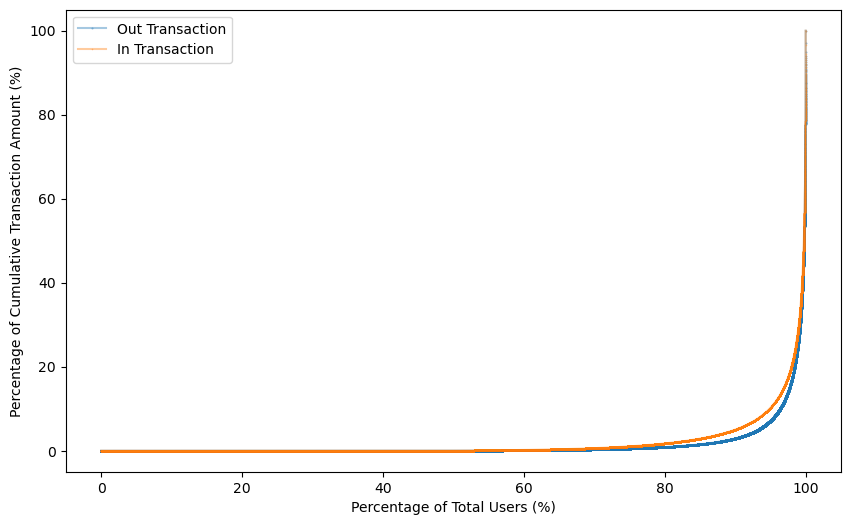

In [13]:

sorted_out_df = merged_df.sort_values(by ='out_total').reset_index(drop=True)
sorted_out_df['cumulative_out_total'] = sorted_out_df['out_total'].cumsum()
sorted_out_df['user_percentage'] = (sorted_out_df.index + 1) / len(sorted_out_df) * 100
sorted_out_df['cumulative_out_total_percentage'] = sorted_out_df['cumulative_out_total'] / sorted_out_df['out_total'].sum() * 100


sorted_in_df = merged_df.sort_values(by='in_total').reset_index(drop=True)
sorted_in_df['cumulative_in_total'] = sorted_in_df['in_total'].cumsum()
sorted_in_df['user_percentage'] = (sorted_in_df.index + 1) / len(sorted_in_df) * 100
sorted_in_df['cumulative_in_total_percentage'] = sorted_in_df['cumulative_in_total'] / sorted_in_df['in_total'].sum() * 100


plt.figure(figsize=(10, 6))
plt.plot(sorted_out_df['user_percentage'], sorted_out_df['cumulative_out_total_percentage'], marker='o', label='Out Transaction',markersize=0.5,alpha=0.4)


plt.plot(sorted_in_df['user_percentage'], sorted_in_df['cumulative_in_total_percentage'], marker='x', label='In Transaction',markersize=0.5,alpha=0.4)


plt.xlabel('Percentage of Total Users (%)')
plt.ylabel('Percentage of Cumulative Transaction Amount (%)')
plt.legend()
plt.show()

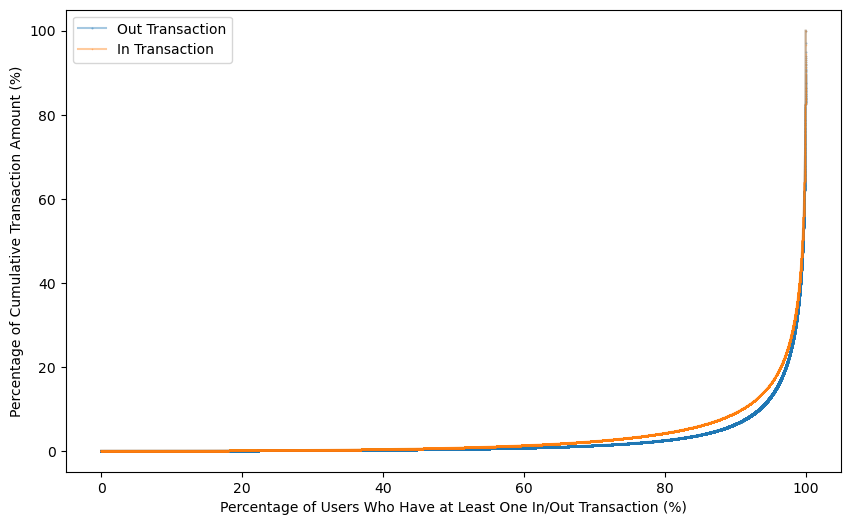

In [14]:
filter_df = merged_df[merged_df['out_degree'] > 0]
sorted_out_df = filter_df.sort_values(by ='out_total').reset_index(drop=True)
sorted_out_df['cumulative_out_total'] = sorted_out_df['out_total'].cumsum()
sorted_out_df['user_percentage'] = (sorted_out_df.index + 1) / len(sorted_out_df) * 100
sorted_out_df['cumulative_out_total_percentage'] = sorted_out_df['cumulative_out_total'] / sorted_out_df['out_total'].sum() * 100

filter_df = merged_df[merged_df['in_degree'] > 0]
sorted_in_df = filter_df.sort_values(by='in_total').reset_index(drop=True)
sorted_in_df['cumulative_in_total'] = sorted_in_df['in_total'].cumsum()
sorted_in_df['user_percentage'] = (sorted_in_df.index + 1) / len(sorted_in_df) * 100
sorted_in_df['cumulative_in_total_percentage'] = sorted_in_df['cumulative_in_total'] / sorted_in_df['in_total'].sum() * 100


plt.figure(figsize=(10, 6))
plt.plot(sorted_out_df['user_percentage'], sorted_out_df['cumulative_out_total_percentage'], marker='o', label='Out Transaction',markersize=0.5,alpha=0.4)


plt.plot(sorted_in_df['user_percentage'], sorted_in_df['cumulative_in_total_percentage'], marker='x', label='In Transaction',markersize=0.5,alpha=0.4)


plt.xlabel('Percentage of Users Who Have at Least One In/Out Transaction (%)')
plt.ylabel('Percentage of Cumulative Transaction Amount (%)')
plt.legend()
plt.show()

# discover some relationships

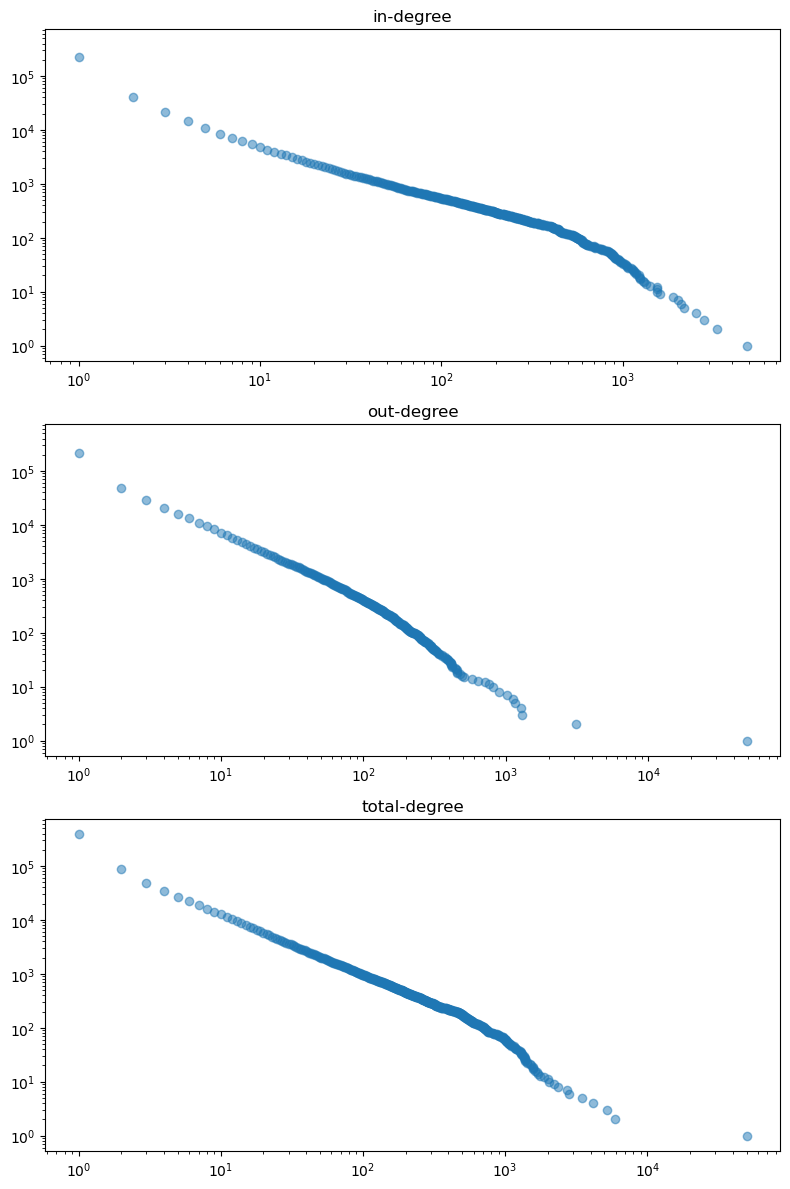

In [19]:
utils.degree_scatter(libra_G,type_list=['in','out','total'],log=True, alpha=0.5)

Calculating best minimal value for power law fit


Power law coefficient (alpha): 2.155102967544903


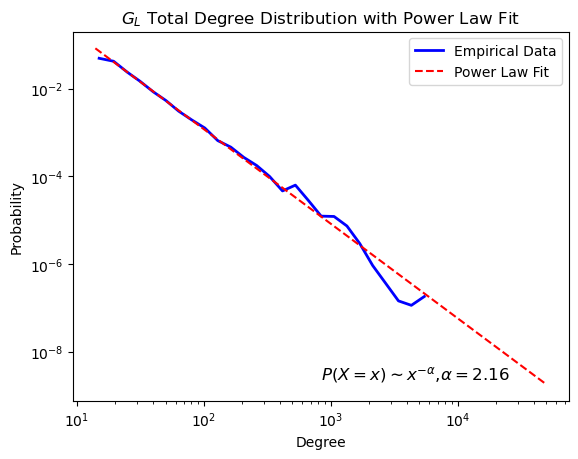

In [32]:
import powerlaw
total_degrees = [d for n, d in libra_G.degree()]

# Fit the degree distribution to a power law
fit = powerlaw.Fit(total_degrees,cumulative=True)

# Extract the power law coefficient (alpha)
alpha = fit.power_law.alpha
print(f"Power law coefficient (alpha): {alpha}")

# Plot the degree distribution and the fitted power law
fig = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig)

text_str = f'$P(X = x) \sim x^{{-\\alpha}}$,$\\alpha = {alpha:.2f}$'
plt.text(0.5, 0.1, text_str, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title(r'$G_{L}$ Total Degree Distribution with Power Law Fit')
plt.legend(['Empirical Data', 'Power Law Fit'])
plt.show()


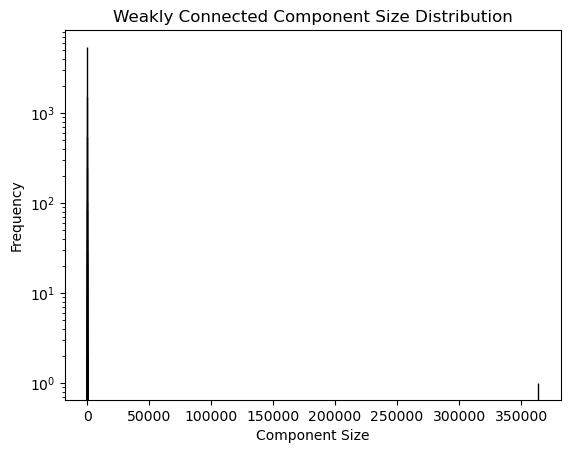

In [33]:
wcc_sizes = [len(c) for c in nx.weakly_connected_components(libra_G)]

# Plot the size distribution of weakly connected components
plt.hist(wcc_sizes, bins=range(1, max(wcc_sizes) + 1), edgecolor='black')
plt.xlabel('Component Size')
plt.ylabel('Frequency')
plt.title('Weakly Connected Component Size Distribution')
plt.yscale('log')  # Use a log scale if component sizes span several orders of magnitude
plt.show()